# Rapids on Colab
A gentle introduction to cuDF and cuML

## Setup:
* activate GPU runtime and check for T4 GPU (Rapids needs CUDA capability >=7!)

In [1]:
#get GPU info
!nvidia-smi

Mon May 26 09:43:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# cuDF and cuML Examples #

Now you can run code!

What follows are basic examples where all processing takes place on the GPU.

#cuDF

see [cuDF API docs](https://docs.rapids.ai/api/cudf/stable/user_guide/) for details

Load a dataset into a GPU memory resident DataFrame and perform a basic calculation.

Everything from CSV parsing to calculating tip percentage and computing a grouped average is done on the GPU.

_Note_: You must import nvstrings and nvcategory before cudf, else you'll get errors.

In [2]:
import cudf
import io, requests

# download CSV file from GitHub
url="https://github.com/plotly/datasets/raw/master/tips.csv"
content = requests.get(url).content.decode('utf-8')

# read CSV from memory
df = cudf.read_csv(io.StringIO(content))
df['tip_percentage'] = df['tip']/df['total_bill']*100

df.head()

,total_bill,tip,sex,smoker,day,time,size,tip_percentage
0,16.99,1.01,Female,No,Sun,Dinner,2,5.944673
1,10.34,1.66,Male,No,Sun,Dinner,3,16.054159
2,21.01,3.50,Male,No,Sun,Dinner,3,16.658734
3,23.68,3.31,Male,No,Sun,Dinner,2,13.978041
4,24.59,3.61,Female,No,Sun,Dinner,4,14.680765


#cuML Example: KMEANS

see [cuML API docs](https://docs.rapids.ai/api/cuml/nightly/api.html) for details on the ML algorithms

In [3]:
import cudf
import cupy
import matplotlib.pyplot as plt
from cuml.cluster import KMeans as cuKMeans
from cuml.datasets import make_blobs
from sklearn.cluster import KMeans as skKMeans
from sklearn.metrics import adjusted_rand_score

%matplotlib inline

In [4]:
# params
n_samples = 10000000
n_features = 2

n_clusters = 5
random_state = 0

In [5]:
#genrate dummy data
device_data, device_labels = make_blobs(n_samples=n_samples,
                                        n_features=n_features,
                                        centers=n_clusters,
                                        random_state=random_state,
                                        cluster_std=0.1)

device_data = cudf.DataFrame(device_data)
device_labels = cudf.Series(device_labels)

In [6]:
# Copy dataset from GPU memory to host memory.
# This is done to later compare CPU and GPU results.
host_data = device_data.to_pandas()
host_labels = device_labels.to_pandas()

In [7]:
## train SK-Learn model on CPU
%%time
kmeans_sk = skKMeans(init="k-means++",
                     n_clusters=n_clusters,
                    random_state=random_state)

kmeans_sk.fit(host_data)

CPU times: user 4.66 s, sys: 372 ms, total: 5.03 s
Wall time: 5.11 s


KMeans(n_clusters=5, random_state=0)

In [8]:
## train cuML model on GPU
%%time
kmeans_cuml = cuKMeans(init="k-means||",
                       n_clusters=n_clusters,
                       oversampling_factor=40,
                       random_state=random_state)

kmeans_cuml.fit(device_data)

CPU times: user 1.3 s, sys: 64.3 ms, total: 1.36 s
Wall time: 1.55 s


/usr/local/lib/python3.11/dist-packages/cuml/internals/api_decorators.py:195: FutureWarning: The default value of `n_init` will change from 1 to 'auto' in 25.04. Set the value of `n_init` explicitly to suppress this warning.
  return func(*args, **kwargs)


KMeans()

#Visualize Centroids

Scikit-learn's k-means implementation uses the `k-means++` initialization strategy while cuML's k-means uses `k-means`.
As a result, the exact centroids found may not be exact as the std deviation of the points around the centroids in `make_blobs` is increased.

*Note*: Visualizing the centroids will only work when `n_features = 2`

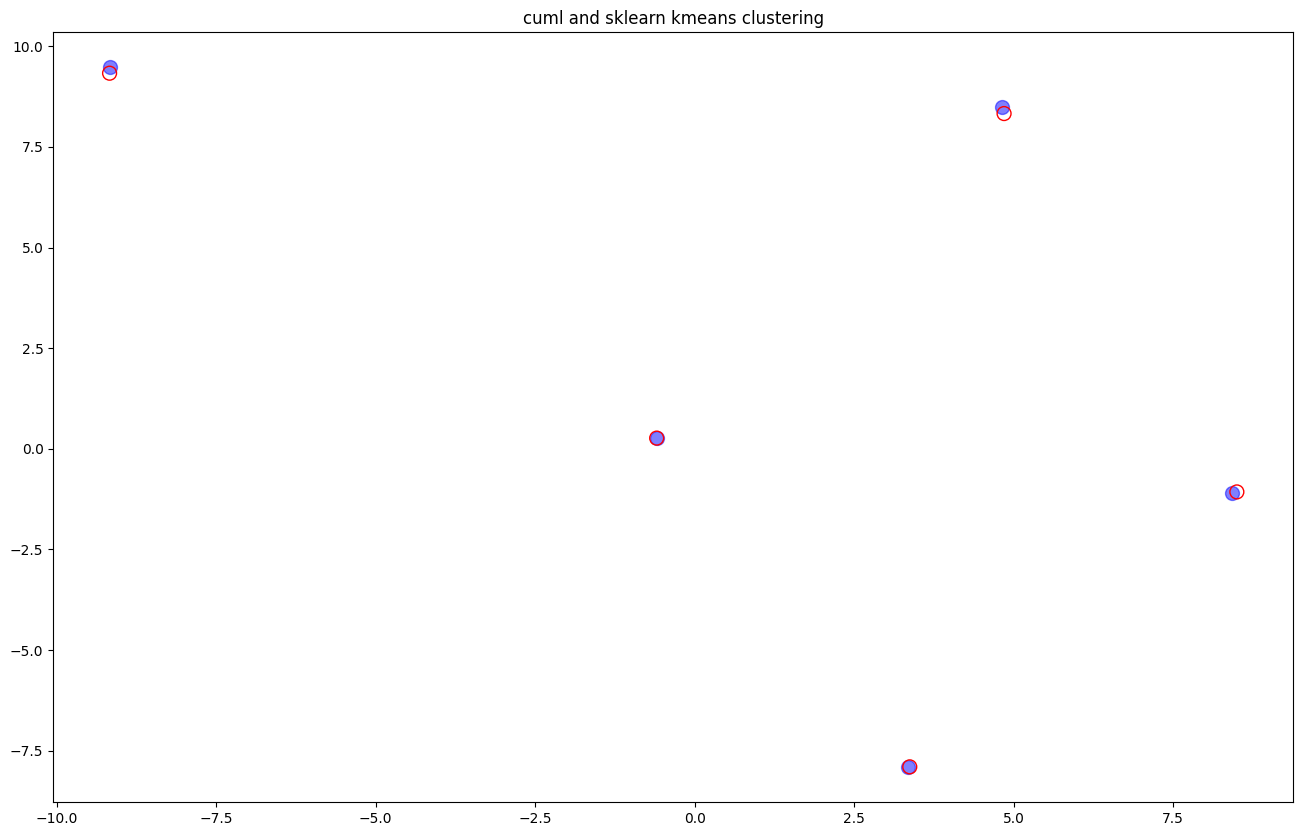

In [9]:
fig = plt.figure(figsize=(16, 10))

#plot the sklearn kmeans centers with blue filled circles
centers_sk = kmeans_sk.cluster_centers_
plt.scatter(centers_sk[:,0], centers_sk[:,1], c='blue', s=100, alpha=.5)

#plot the cuml kmeans centers with red circle outlines
centers_cuml = kmeans_cuml.cluster_centers_
plt.scatter(cupy.asnumpy(centers_cuml[0].values),
            cupy.asnumpy(centers_cuml[1].values),
            facecolors = 'none', edgecolors='red', s=100)

plt.title('cuml and sklearn kmeans clustering')

plt.show()

# cuML Example RF

In [10]:
import cudf
import numpy as np
import pandas as pd
import pickle

from cuml.ensemble import RandomForestClassifier as curfc
from cuml.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier as skrfc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [11]:
# params
n_samples = 2**12
n_features = 399
n_info = 300
data_type = np.float32

In [12]:
# gen data
X,y = make_classification(n_samples=n_samples,
                          n_features=n_features,
                          n_informative=n_info,
                          random_state=123, n_classes=2)

X = pd.DataFrame(X.astype(data_type))
# cuML Random Forest Classifier requires the labels to be integers
y = pd.Series(y.astype(np.int32))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=0)


In [13]:
#move data to GPU
X_cudf_train = cudf.DataFrame.from_pandas(X_train)
X_cudf_test = cudf.DataFrame.from_pandas(X_test)

y_cudf_train = cudf.Series(y_train.values)

In [14]:
# SK-Learn model
%%time
sk_model = skrfc(n_estimators=40,
                 max_depth=16,
                 max_features=1.0,
                 random_state=10)

sk_model.fit(X_train, y_train)

CPU times: user 48.4 s, sys: 94.2 ms, total: 48.5 s
Wall time: 48.5 s


RandomForestClassifier(max_depth=16, max_features=1.0, n_estimators=40,
                       random_state=10)

In [15]:
# cuML model
%%time
cuml_model = curfc(n_estimators=40,
                   max_depth=16,
                   max_features=1.0)

cuml_model.fit(X_cudf_train, y_cudf_train)

CPU times: user 1.56 s, sys: 292 ms, total: 1.85 s
Wall time: 1.53 s


RandomForestClassifier()

In [16]:
#eval
%%time
sk_predict = sk_model.predict(X_test)
sk_acc = accuracy_score(y_test, sk_predict)

CPU times: user 26.3 ms, sys: 1.06 ms, total: 27.4 ms
Wall time: 27.4 ms


In [17]:
%%time
fil_preds_orig = cuml_model.predict(X_cudf_test)

fil_acc_orig = accuracy_score(y_test.to_numpy(), fil_preds_orig)

CPU times: user 173 ms, sys: 71.8 ms, total: 245 ms
Wall time: 258 ms
